### An introduction to how machine learning can help us analyze millions of solar spectra efficiently  
#### Notebook 4. Mutual Information 
*by Brandon Panos*$^{1,2}$  

1 *University of Applied Sciences and Arts Northwestern Switzerland, Bahnhofstrasse 6, 5210 Windisch, Switzerland*  
2 *University of Geneva, CUI-SIP, 1205 Geneva, Switzerland*

**----------------------------------------------------------------------------------------------------------------------------**    

### Mutual information neural estimation (MINE)  
In this notebook, I will show you how to calculate the ***mutual information (MI)*** between two different pairs of IRIS spectral lines using a neural network called a ***MINE-network***. This method was developed recently by <font color='dodgerblue'>Belghazi et al PMLR 80:531-540, 2018</font>. Our results can be found in the published article <font color='dodgerblue'>Panos et al 2021 ApJ 912 121</font>.  

***Why calculate MI?:***
Two random variables can be correlated in a highly complex non-linear fashion. The normal covariance measure $\sigma$, only captures linear correlations. The following figure makes it clear that covariance is simply a subset of the MI, which itself captures all dependancies, both linear and non-linear. Mathematically, the MI between two random variables is given by  

$$
M I(X ; Y)=\sum_{x} \sum_{y} p(x, y) \log \frac{p(x, y)}{p(x) p(y)},
$$

and is the KL-divergence (distance) between the joint probability distribution $p(x, y)$ and the product of the marginals $p(x) p(y)$. The latter tells us what the baseline uncorrelated distribution should look like, while the joint distribution is the actual probability distribution between the two variables. The more these two distributions differ, the higher the MI.

<img src="pics/MI_VS_COV.png" width="1000">   
The first panel in the above figure shows a scatter plot of all the pair-wise datasets in the WHOs database. The Second panel shows a randomly distributed dataset taken from this database. Since there is no correlation between the two variables, it scores low on both MI and covariance. The third panel shows a strong linear correlation which is picked up by both statistical measure. The final panel shows a distribution with a non-linear correlation that is missed by the covariance, but subsequently picked up by the MI. 

***How do we calculate the MI?***
<img src="pics/MI.png" width="1000">  
There exists a dual representation that allows us to parameterize the MI in terms of a neural network, for more details see <font color='dodgerblue'>Panos et al 2021 ApJ 912 121</font>. The fancy part of the MINE-network is not its architecture, but rather how it samples the data. Notice that we take spectra from two different pixel locations. The upper half of the network takes spectra from line $\mathcal{L}1$ and $\mathcal{L}2$ from the same pixel, and therefore samples from the joint probability distribution $p(x, y)$. The lower half of the network takes spectra from different pixels, and therefore samples form the product of the marginals, since we assume that the data in the two pixels are uncorrelated. The spectra in both the upper and lower channels are processed the same way. They are compressed by an encoder, concatenated and then compressed again to a real number. We don’t impose any restrictions on how the network maps from complex raw spectral inputs to a single real number. We then ask the network to distinguish between the upper and lower channels by any means necessary. Since the lower channel samples from two random pixels, it is estimating the baseline uncorrelated state. Therefore, the only way the network can distinguish between the two channels it to learn all possible correlations that exist between the two lines sourced from the same pixels. The extent to which the network can separate the two real number outputs is proportional to the MI. In fact, it can be shown that the MI estimated in this way forms a tight lower bound on the actual MI.  

***Why should this network interest you?***
1) The MINE-network is compatible with any data type. 2) It is applied directly on the raw data, no additional transformations needed. 3) You can measure the MI between two very different data types, e.g., images and spectra. 4) The MI can be used as an important component in other more complex generative models such as InfoGANs. 

In [144]:
import torch
import pickle
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch.nn.functional as F
import torchvision.transforms as T

### Calculating the MI between different IRIS spectral lines during a flare

I will show you how to perform the above calculation for two different pairs of IRIS spectral data taken from a single solar flare. We will compare the MI of the <font color='darkred'>(Mg II | C II)</font> line pair and the <font color='darkblue'>(Mg II | FeII)</font> line pair. Since Mg II and C II have a similar formation hight and atomic physics, we expect that this correlation is much higher than that Fe II, which forms low down in the photosphere. Lets see if this is true. 

In [372]:
def data_loader(name1='MgII', name2='CII'):
    
    fhand = np.load('data/'+name1+'_Spectra.npz')
    data = fhand['data']
    nprof1 = profile_rep( data )

    fhand = np.load('data/'+name2+'_Spectra.npz')
    data = fhand['data']
    nprof2 = profile_rep( data )
    
    return nprof1, nprof2

def profile_rep(data):
    '''
    reshape data form (step, raster, y, lambda) to (m, lambda)
    '''
    data_transposed = np.transpose(data, (1,0,2,3))
    nprof = data_transposed.reshape( data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], order='C' )
    return nprof

def sample_data(nprof1, nprof2, num_samples):
    '''
    sample n random pixels containing spectra from line1 and line2
    '''
    inds = np.random.randint(nprof1.shape[0], size=num_samples)
    sub_nprof1 =  nprof1[inds, :]
    sub_nprof2 =  nprof2[inds, :]
    return sub_nprof1, sub_nprof2

def clean_nans(nprof1, nprof2):
    '''
    remove any pixels with either or any of the spectra containing nan values
    '''
    inds1 = np.argwhere(~np.isnan(nprof1).any(axis=1) == False)
    inds2 = np.argwhere(~np.isnan(nprof2).any(axis=1) == False)
    inds = np.concatenate( (inds1, inds2) )
    inds = np.squeeze( np.unique( inds ) )
    clean_nprof1 = np.delete(nprof1, inds, axis=0)
    clean_nprof2 = np.delete(nprof2, inds, axis=0)
    return clean_nprof1, clean_nprof2

In [379]:
# Define the network in the figure using PyTorch

class MIEstimator1(nn.Module):
    def __init__(self, d1, d2, d_z):
        super(MIEstimator1, self).__init__()
        
        self.fc1 = nn.Linear(d1, d_z)
        self.fc2 = nn.Linear(d2, d_z)
        
        self.fc3 = nn.Linear(2*d_z, d_z)
        self.fc4 = nn.Linear(d_z, 1)

    def forward(self, x, y):

        x = self.fc1(x)
        y = self.fc2(y)
        
        out = torch.cat((x, y), 1)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        
        return out

In [381]:
# Calculate the MI for Mg II and C II at each step of the network training

num_samples = 1000
n_epoch = 100

nprof1, nprof2 = data_loader(name1='MgII', name2='CII')
clean_nprof1, clean_nprof2 = clean_nans(nprof1, nprof2) 

model = MIEstimator1(nprof1.shape[1], nprof2.shape[1], 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mi_hist1 = []
for epoch in range(n_epoch):
    x_sample, y_sample = sample_data(clean_nprof1, clean_nprof2, num_samples)
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)

    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist1.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

In [382]:
# Calculate the MI for Mg II and Fe II at each step of the network training

nprof1, nprof2 = data_loader(name1='MgII', name2='FeII')
clean_nprof1, clean_nprof2 = clean_nans(nprof1, nprof2)

model = MIEstimator1(nprof1.shape[1], nprof2.shape[1], 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mi_hist2 = []
for epoch in range(n_epoch):
    x_sample, y_sample = sample_data(clean_nprof1, clean_nprof2, num_samples)
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)

    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist2.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

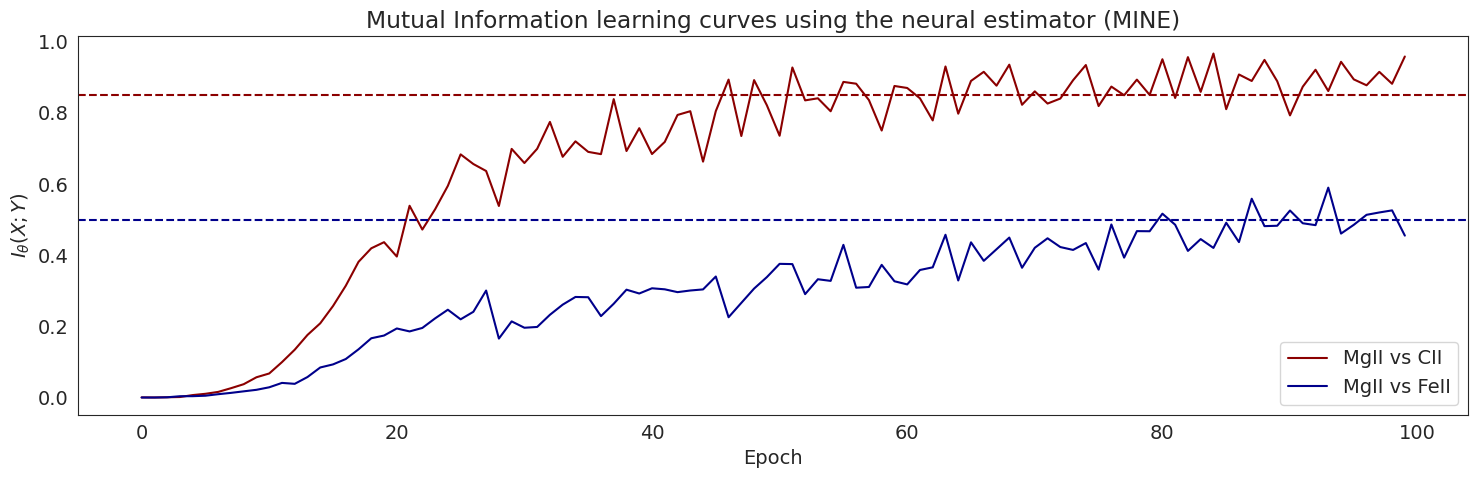

In [383]:
# Plot results

fig, ax = plt.subplots(figsize=(15,5))
rcParams['font.size'] = 14
sns.set_style("white")
plt.title('Mutual Information learning curves using the neural estimator (MINE)')

plt.plot(range(0, n_epoch), mi_hist1, c='darkred', label='MgII vs CII')
plt.plot(range(0, n_epoch), mi_hist2, c='darkblue', label='MgII vs FeII')
plt.axhline(.85, c='darkred', linestyle='--')
plt.axhline(.5, c='darkblue', linestyle='--')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$I_\theta(X;Y)$')
plt.tight_layout()
plt.show()

As expected, the MI is higher between the chromospheric line-pair <font color='darkred'>(Mg II | C II)</font> than <font color='darkblue'>(Mg II | Fe II)</font>. Notice that it takes some time for the network to converge on the actual MI. This means that if we know what an Mg II spectrum looks like, we should be able to predict how C II will respond. Sometimes the network initiates badly or selects an unfortunate sample. If this is the case simply repeat the calculation util convergence. 

### Calculating the MI between different Mg II line features 

In [386]:
# Load quiet Sun dataset
with open('data/qs_spectra.p', 'rb') as f: qs_spectra = pickle.load(f)
with open('data/qs_features.p', 'rb') as f: qs_features = pickle.load(f)
# Load flare dataset
with open('data/fl_spectra.p', 'rb') as f: fl_spectra = pickle.load(f)
with open('data/fl_features.p', 'rb') as f: fl_features = pickle.load(f) 

In [387]:
def data_loader( features, name1='intensity', name2='triplet_intensity' ):
    
    # Load feature features and reshape into vertical vectors  
    fet1 = features[name1].reshape( -1, 1 )
    fet2 = features[name2].reshape( -1, 1 )
    
    # standardize to the same support
    fet1 = (fet1 - np.mean(fet1)) / np.std(fet1)
    fet2 = (fet2 - np.mean(fet2)) / np.std(fet2)
    
    return fet1, fet2

def sample_data(fet1, fet2, num_samples):
    '''
    sample n random pixels containing spectra from line1 and line2
    '''
    inds = np.random.randint(len(fet1), size=num_samples)
    sub_fet1 =  fet1[inds]
    sub_fet2 =  fet2[inds]
    return sub_fet1, sub_fet2

In [388]:
# Define the network in the figure using PyTorch

class MIEstimator1(nn.Module):
    def __init__(self, d1, d2, d_z):
        super(MIEstimator1, self).__init__()
        self.fc1 = nn.Linear(d1, d_z)
        self.fc2 = nn.Linear(d2, d_z)
        self.fc3 = nn.Linear(d_z, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2 

## ! Exercises

In [397]:
'''
Q1) Calculate the MI between the intensity and triplet_intensity and plot the results
'''

In [398]:
'''
Q2) Calculate the MI for every feature-pair combination. Rank and plot the results
'''

## ! End of exercises